In [ ]:
%tensorflow_version 2.x

!pip install tensorboardX

!pip install tf_slim

     |████████████████████████████████| 124 kB 7.3 MB/s 
     |████████████████████████████████| 352 kB 7.0 MB/s 


In [ ]:
import gym
import numpy as np
import tensorflow as tf
import collections
import datetime
import tf_slim as slim
from tensorboardX import SummaryWriter

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline               


Actor-Critic

In [ ]:
class PolicyNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='policy_network'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            global_step = tf.Variable(0, trainable=False)

            learning_rate = tf.train.exponential_decay(self.learning_rate, global_step,
                                       1000, 0.95, staircase=True)
            
            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.action = tf.placeholder(tf.int32, [self.action_size], name="action")
            self.R_t = tf.placeholder(tf.float32, name="total_rewards")

            self.W1 = tf.get_variable("W1", [self.state_size, 12], initializer=tf.keras.initializers.glorot_normal(seed=0))
            self.b1 = tf.get_variable("b1", [12], initializer=tf.zeros_initializer())
            self.W2 = tf.get_variable("W2", [12, self.action_size], initializer=tf.keras.initializers.glorot_normal(seed=0))
            self.b2 = tf.get_variable("b2", [self.action_size], initializer=tf.zeros_initializer())

            self.Z1 = tf.add(tf.matmul(self.state, self.W1), self.b1)
            self.A1 = tf.nn.relu(self.Z1)
            self.output = tf.add(tf.matmul(self.A1, self.W2), self.b2)

            # Softmax probability distribution over actions
            self.actions_distribution = tf.squeeze(tf.nn.softmax(self.output)) 
            # Loss with negative log probability
            self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.output, labels=self.action)
            self.loss = tf.reduce_mean(self.neg_log_prob * self.R_t)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss, global_step=global_step)

In [ ]:
class ValueEstimator():
    
    def __init__(self, state_size, action_size, learning_rate, name='value_network'):
        self.state_size = state_size
        self.action_size = action_size 
        self.learning_rate = learning_rate
        
        self.n_outputs = 1
        # Define number of hidden nodes
        self.n_hidden_nodes = 16
        
        with tf.variable_scope(name):
            global_step = tf.Variable(0, trainable=False)

            learning_rate = tf.train.exponential_decay(self.learning_rate, global_step,
                                       1000, 0.98, staircase=True)
            
            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.action = tf.placeholder(tf.int32, [self.action_size], name="action") 
            self.R_t = tf.placeholder(tf.float32, name="total_rewards")

            initializer = tf.keras.initializers.glorot_normal(seed=0)

            layer_1 = slim.fully_connected(self.state, self.n_hidden_nodes, activation_fn=tf.nn.relu, weights_initializer=initializer)
            output_layer = slim.fully_connected(layer_1, self.n_outputs, activation_fn=None, weights_initializer=initializer)
            
            self.state_value_estimation = tf.squeeze(output_layer)
    
            # Define loss function as squared difference between estimate and actual
            self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.R_t))
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss, global_step=global_step)

In [ ]:
env = gym.make('CartPole-v1')

np.random.seed(1)
writer = SummaryWriter()
# Define hyperparameters
state_size = 4
action_size = env.action_space.n

max_episodes = 5000
max_steps = 501
discount_factor = 0.99
learning_rate_value = 0.01
learning_rate_policy = 0.001
render = False

# Initialize the policy network
tf.reset_default_graph()
policy = PolicyNetwork(state_size, action_size, learning_rate_policy)
value = ValueEstimator(state_size, action_size, learning_rate_value)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Episode 0 Reward: 11.0 Average over 100 episodes: 0.0
Mean Value Loss: 0.985829770565033, Mean Policy Loss: 0.588636040687561
Episode 1 Reward: 66.0 Average over 100 episodes: 0.0
Mean Value Loss: 1.1857959032058716, Mean Policy Loss: 0.4530952274799347
Episode 2 Reward: 14.0 Average over 100 episodes: 0.0
Mean Value Loss: 17.20844268798828, Mean Policy Loss: 0.16825342178344727
Episode 3 Reward: 25.0 Average over 100 episodes: 0.0
Mean Value Loss: 9.04701042175293, Mean Policy Loss: 0.34330862760543823
Episode 4 Reward: 20.0 Average over 100 episodes: 0.0
Mean Value Loss: 9.078557014465332, Mean Policy Loss: 0.2149103879928589
Episode 5 Reward: 46.0 Average over 100 episodes: 0.0
Mean Value Loss: 6.525184154510498, Mean Policy Loss: 0.19886381924152374
Episode 6 Reward: 20.0 Average over 100 episodes: 0.0
Mean Value Loss: 9.367822647094727, Mean Policy Loss: 0.3008207082748413
Episode 7 Reward: 9.0 Average over 100 episodes: 0.0
Mean Value Loss: 19.985401153564453, Mean Policy Loss: 0

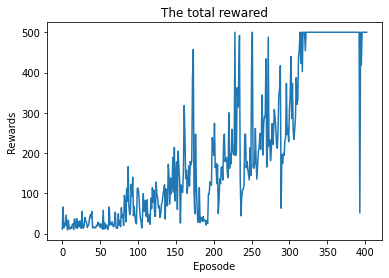

In [ ]:
# Start training the agent with REINFORCE algorithm
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    solved = False
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    episode_rewards = np.zeros(max_episodes)
    average_rewards = 0.0
    for episode in range(max_episodes):
        state = env.reset()
        state = state.reshape([1, state_size])
        I = 1
        episode_transitions = []
        episode_val_losses = []
        episode_policy_losses = []

        for step in range(max_steps):
            actions_distribution = sess.run(policy.actions_distribution, {policy.state: state})
            action = np.random.choice(np.arange(len(actions_distribution)), p=actions_distribution)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.reshape([1, state_size])

            if render:
                env.render()

            action_one_hot = np.zeros(action_size)
            action_one_hot[action] = 1
            
            episode_transitions.append(Transition(state=state, action=action_one_hot, reward=reward, next_state=next_state, done=done))
            episode_rewards[episode] += reward

            # Compute value estimations
            estimated_return_state = sess.run([value.state_value_estimation], {value.state: state})[0]
            if not done:
              estimated_return_next_state = sess.run([value.state_value_estimation], {value.state: next_state})[0]
              discounted_estimated_return_next_state = discount_factor * estimated_return_next_state
            else:
              discounted_estimated_return_next_state = 0
            # Compute TD-error 
            delta = (reward + discounted_estimated_return_next_state) - estimated_return_state
            delta_I = I * delta
            

            # Value function update
            value_feed_dict= {value.state: state, value.R_t: reward + discounted_estimated_return_next_state} 
            _, val_loss = sess.run([value.optimizer, value.loss], value_feed_dict)
            episode_val_losses.append(val_loss)
            # Policy function update
            feed_dict = {policy.state: state, policy.R_t: delta_I, policy.action: action_one_hot} 
            _, policy_loss = sess.run([policy.optimizer, policy.loss], feed_dict)
            episode_policy_losses.append(policy_loss)

            if done:
                if episode > 98:
                    # Check if solved
                    average_rewards = np.mean(episode_rewards[(episode - 99):episode+1])
                print("Episode {} Reward: {} Average over 100 episodes: {}".format(episode, episode_rewards[episode], round(average_rewards, 2)))
                print(f"Mean Value Loss: {np.mean(episode_val_losses)}, Mean Policy Loss: {np.mean(episode_policy_losses)}")
                if average_rewards > 475:
                    print(' Solved at episode: ' + str(episode))
                    solved = True
                break
            state = next_state
            I = discount_factor * I
        writer.add_scalar('Total Reward', episode_rewards[episode], episode)
        writer.add_scalar('Steps', step, episode)

        if solved:
            break

    writer.close()


    plt.plot(range(episode),episode_rewards[:episode])
    plt.xlabel('Eposode')
    plt.ylabel('Rewards')
    plt.title('The total rewared')
    plt.show()

In [ ]:
%reload_ext tensorboard 
%tensorboard --logdir ".logs/"


In [ ]:

%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 298), started 0:00:04 ago. (Use '!kill 298' to kill it.)

<IPython.core.display.Javascript object>